# Modelos de datos

**Notebook de seguimiento**

```
Ezequiel Cimadevilla Álvarez
ezequiel.cimadevilla@unican.es

Santander Meteorology Group
Instituto de Física de Cantabria
Edificio Juan Jordá, Avenida de los Castros, s/n, E-39005 Santander, Cantabria, Spain

http://www.meteo.unican.es

Máster Data Science/Ciencia de Datos - 2024/2025
```

## Contents

* [Intro](#intro)
* [h5py and random walker](#h5py-and-random-walker)
* [Chunking and filters](#chunking-and-filters)
* [Attributes](#attributes)
* [netCDF](#netcdf)
* [Dimension scales](#dimension-scales)
* [Virtual dataset](#virtual-dataset)
* [Discrete Sampling Geometries](#dsg)
* [Zarr](#zarr)

# Intro <a class="anchor" id="intro"/>

In [2]:
import h5py
import numpy as np

Follow the [tutorial](https://docs.h5py.org/en/stable/quick.html#appendix-creating-a-file) and answer the questions:

- Which modes are available in HDF5 when opening a File?
- Which method/function can be used to recursively iter over an entire group?
- Execute the following command in a terminal: `h5dump -A FILE`. What do you see?

Which modes are available in HDF5 when opening a File?

In [2]:
# Crear un archivo nuevo ('w') - si existe lo sobre escribe 
with h5py.File('archivo_1.hdf5', 'w') as f:
    f.create_dataset('datos', data=[1, 2, 3])

In [3]:
# Abrir el archivo en modo lectura ('r')
with h5py.File('archivo_1.hdf5', 'r') as f:
    print(f['datos'][:])

[1 2 3]


In [4]:
# Abrir para lectura/escritura ('r+')
with h5py.File('archivo_1.hdf5', 'r+') as f:
    f['datos'][0] = 10
    print(f['datos'][:])

[10  2  3]


In [6]:
#Abre un archivo existente para lectura/escritura o crea uno nuevo si no existe (no sobre escribe). ('a')
#nuevo
with h5py.File('archivo_2.hdf5', 'a') as f:
    f.create_dataset('datos', data=[4, 5, 6])
    print(f['datos'][:])

[4 5 6]


In [7]:
#Abre un archivo existente para lectura/escritura o crea uno nuevo si no existe (no sobre escribe). ('a')
#existente
with h5py.File('archivo_2.hdf5', 'a') as f:
    f['datos'][0] = 12
    print(f['datos'][:])

[12  5  6]


In [8]:
# Intentar crear un archivo sin sobrescribir (modo 'w-')
with h5py.File('archivo_1.hdf5', 'w-') as f:
    f.create_dataset('datos', data=[1, 2, 3]) ## sale error porque no puede sobre escribir

FileExistsError: [Errno 17] Unable to synchronously create file (unable to open file: name = 'archivo_1.hdf5', errno = 17, error message = 'File exists', flags = 15, o_flags = 502)

Which method/function can be used to recursively iter over an entire group?

In [23]:
# crear archivo con un conjunto de datos con la forma y el tipo de datos dados.
with h5py.File("mytestfile.hdf5", "w") as f:
    dset = f.create_dataset("mydataset", (100,), dtype='i')

In [24]:
#creación de subgrupo
#primero abrimos archivo en modo agregar
f = h5py.File('mytestfile.hdf5', 'a')
#agregamos subgrupo
grp = f.create_group("subgroup")
#CReando archivo
dset2 = grp.create_dataset("another_dataset", (50,), dtype='f')
#creamos subgrupo y archivo (al mismo tiempo)
dset3 = f.create_dataset('subgroup2/another_dataset2', (10,), dtype='i')

In [25]:
#iteración sobre un archivo completo se logra con los métodos visit()y visititems() - respuesta a pregunta
def printname(name):
    print(name)
f.visit(printname)

mydataset
subgroup
subgroup/another_dataset
subgroup2
subgroup2/another_dataset2


In [26]:
f.close()

Execute the following command in a terminal: h5dump -A FILE. What do you see?

In [27]:
!h5dump -A mytestfile.hdf5

HDF5 "mytestfile.hdf5" {
GROUP "/" {
   DATASET "mydataset" {
      DATATYPE  H5T_STD_I32LE
      DATASPACE  SIMPLE { ( 100 ) / ( 100 ) }
   }
   GROUP "subgroup" {
      DATASET "another_dataset" {
         DATATYPE  H5T_IEEE_F32LE
         DATASPACE  SIMPLE { ( 50 ) / ( 50 ) }
      }
   }
   GROUP "subgroup2" {
      DATASET "another_dataset2" {
         DATATYPE  H5T_STD_I32LE
         DATASPACE  SIMPLE { ( 10 ) / ( 10 ) }
      }
   }
}
}


In [ ]:
##Se obsrva el contenido del archivo, como su nombre, grupos, atributos, etc. 

## NumPy

This is just a small section to review Numpy. Execute the examples and solve the exercises.

In [49]:
import numpy as np

We can emulate multidimensional arrays using ragged arrays (arrays inside of arrays). Why is this a bad idea? Read [this](https://docs.python.org/3.7/faq/design.html#how-are-lists-implemented-in-cpython).

In [50]:
l0 = [100, 200, 50, 400]
l1 = [50, 0, 0, 100]
l2 = [350, 100, 50, 200]
ls = [l0, l1, l2]
print(ls)

[[100, 200, 50, 400], [50, 0, 0, 100], [350, 100, 50, 200]]


Let's see how this performs compared to NumPy.

In [51]:
L = range(1000)
%timeit [i**2 for i in L]

74.1 μs ± 6.35 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [52]:
a = np.arange(1000)
%timeit a**2

1.28 μs ± 72.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Let's see some NumPy properties.

In [53]:
a = np.array([[100, 200, 50, 400], [50, 0, 0, 100], [350, 100, 50, 200]])

def print_info(a):
    print('number of elements:', a.size)
    print('number of dimensions:', a.ndim)
    print('shape:', a.shape)
    print('data type:', a.dtype)
    print('strides:', a.strides) # strides are measured in bytes
    print('flags:')
    print(a.flags)
    
print_info(a)

number of elements: 12
number of dimensions: 2
shape: (3, 4)
data type: int64
strides: (32, 8)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



Copies and views.

In [54]:
b = a.astype(np.uint8) # astype() always creates a copy of the data
print_info(b)

number of elements: 12
number of dimensions: 2
shape: (3, 4)
data type: uint8
strides: (4, 1)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



In [55]:
abytes = a.ravel().view(dtype=np.uint8) # view() does not create a new copy of the data
print_info(abytes)

number of elements: 96
number of dimensions: 1
shape: (96,)
data type: uint8
strides: (1,)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



In [56]:
abytes

array([100,   0,   0,   0,   0,   0,   0,   0, 200,   0,   0,   0,   0,
         0,   0,   0,  50,   0,   0,   0,   0,   0,   0,   0, 144,   1,
         0,   0,   0,   0,   0,   0,  50,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 100,   0,   0,   0,   0,   0,   0,   0,  94,
         1,   0,   0,   0,   0,   0,   0, 100,   0,   0,   0,   0,   0,
         0,   0,  50,   0,   0,   0,   0,   0,   0,   0, 200,   0,   0,
         0,   0,   0,   0,   0], dtype=uint8)

Set the element with index 1 of `abytes` (this is, `abytes[1]`) to 1 and see how `a` changes. **Do you understand the changes?**

In [57]:
abytes[1] = 1
abytes

array([100,   1,   0,   0,   0,   0,   0,   0, 200,   0,   0,   0,   0,
         0,   0,   0,  50,   0,   0,   0,   0,   0,   0,   0, 144,   1,
         0,   0,   0,   0,   0,   0,  50,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 100,   0,   0,   0,   0,   0,   0,   0,  94,
         1,   0,   0,   0,   0,   0,   0, 100,   0,   0,   0,   0,   0,
         0,   0,  50,   0,   0,   0,   0,   0,   0,   0, 200,   0,   0,
         0,   0,   0,   0,   0], dtype=uint8)

In [58]:
a # Cada byte contribuye al valor total del número dependiendo de su posición, 
#multiplicada por una potencia de 256 (porque cada byte tiene 2 a la 8 = 256 valores posibles).

array([[356, 200,  50, 400],
       [ 50,   0,   0, 100],
       [350, 100,  50, 200]])

# h5py and random walker <a class="anchor" id="h5py-and-random-walker"/>

In [21]:
import numpy as np

Generate a matrix named `steps` that contains 10000 rows where every row is a sample of a 200 random steps (that means that `np.shape` is `(10000, 200)` and `np.unique(steps)` is `[-1, 1]`). Use `np.random.randint` to generate random values.

In [22]:
np.random.seed(1012) #semilla
steps = np.random.randint(0, 2, (10_000, 200)) * 2 -1 #generación de pasos aleatoreos
steps

array([[-1,  1,  1, ...,  1,  1, -1],
       [ 1,  1,  1, ..., -1, -1, -1],
       [-1,  1,  1, ..., -1,  1, -1],
       ...,
       [-1, -1, -1, ...,  1, -1,  1],
       [ 1,  1, -1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1,  1]], dtype=int32)

Generate the `positions` matrix, of shape `(10000, 200)` that contains the position of every step of the walk (hint: `np.cumsum`).

In [23]:
#np.cumsum(steps, axis = 1)
positions = steps.cumsum(1)
positions[:,-1] #array de posiciones con suma acumulada

array([ -2,  -8, -14, ...,   6,  12,   6])

Show the number of walks that reached either 30 steps in any of the directions (hint: `np.abs` and `any`).

In [25]:
hits30 = np.any(np.abs(positions) >= 30 , 1) #filtro de casos que cumplen la condición
hits30

array([False, False, False, ..., False, False, False])

In [26]:
walker_30 = hits30.sum() # suma de caminantes que alcanzaron los 30 pasos
print(f"Los caminantes que alcanzaron los 30 pasos fueron {walker_30}")

Los caminantes que alcanzaron los 30 pasos fueron 701


For the walkers that reached 30 steps in any of the directions, show the step at which they reached the longest position (hint: `argmax`).

In [27]:
#submatriz que contiene solo las caminantes que alcanzaron los 30 pasos. Donde se muestra que de los 10 mil, 701 alcanzaron los 30 pasos y cada uno de estos tiene 200 pasos (posiciones)
#argmax: devuelve indice donde el valor es maximo (1 = a lo largo de las columnas)
np.abs(positions)[hits30, :].argmax(1) #array con paso en el que alcanzaron la posición mas larga los caminates

array([197, 199, 138, 155, 123, 195, 198, 199, 198, 195, 186, 198, 199,
       195, 187, 199, 134, 155, 199, 192, 193, 185, 177, 198, 168, 195,
       138, 143, 192, 198, 158, 175, 192, 167, 145, 194, 196, 181, 162,
       170, 197, 198, 185, 196, 196, 133, 196, 148, 172, 177, 176, 149,
       119, 158,  98, 199, 187, 197, 193, 157, 198, 189, 198, 198, 199,
       197, 194, 120, 181, 189, 199,  92, 191, 173, 199, 178, 187, 155,
       197, 172, 140, 162, 189, 180, 195, 194, 177, 199, 193, 199, 132,
       168, 199, 165, 199, 198, 198, 193, 180, 170, 190, 198, 187, 191,
       195, 199, 149, 177, 171, 186, 174, 181, 174, 193, 177, 194, 197,
       165, 199, 170, 185, 198, 199, 196, 199, 196, 194, 115, 117, 162,
       175, 175, 172, 163, 161, 168, 184, 182, 173, 141, 196, 197, 198,
       179, 199, 184, 170, 181, 177, 147, 148, 188, 119, 155, 164, 161,
       198,  97, 182, 199, 187, 190, 177, 191, 182, 197, 188, 178, 186,
       127, 110, 167, 109, 195, 161, 151, 140, 193, 184, 167, 19

## Storing walks in HDF5

Now you will generate lots of random walker samples and you will use HDF5 to store them.

1. Create the HDF5 file named `walks.h5`.
2. Create a dataset named `walks`. The dataset must use **contiguous** storage (not chunked).
3. You will create 10 million random walk samples of length 200 and type `np.int64` and you will store them in the `walks` dataset.
4. Before starting task 4 and based on the size of the dataset and the size of the dtype, can you calculate an approximation of the resulting file size?
5. While the notebook executes the task of storing the walks in the HDF5 file, open the CPU, RAM and disk monitor of your operative system and take a look to resources being used.
6. Answer again the questions from the previous NumPy exercise but using the 10 million walks you have just generated.

In [28]:
import h5py
import numpy as np

In [29]:
n = 10_000_000
l = 200
cs = 10_000

In [30]:
# Punto 1: Abrir archivo HDF5 para escritura 
with h5py.File("walks.h5", "w") as f:
    batch_size = 10000
    size = 10000000
    walk_length = 200
# Punto 2, 3, 6 (posiciones): Crear el dataset "walks" con almacenamiento contiguo. Generar y almacenar datos de tipo np.int64 (posiciones)
    f.create_dataset("walks", (size, walk_length), "f8")
    # Generar y almacenar las caminantes en lotes
    for i in range(0, size, batch_size):
        #steps del caminante - lote de caminantes aleatorias: valores entre -1 y 1
        steps = np.random.randint(0, 2, (batch_size, walk_length)) * 2 - 1
        # Calcular la suma acumulada para obtener las posiciones y almacenar lote
        f["walks"][i:i+batch_size] = np.cumsum(steps, axis=1)
        f.flush()

In [31]:
#revisando información 
# Abrir el archivo HDF5 en modo lectura
with h5py.File("walks.h5", "r") as f:
    # Acceder al dataset 'walks'
    walks = f["walks"]
    # Consultar la forma del dataset
    print("Forma del dataset 'walks':", walks.shape)
    # Ver los primeros 5 caminantes completos
    print("\nPrimeros 5 caminantes (posiciones):")
    print(walks[:5]) 
    # Ver el primer caminante y sus primeros 10 pasos
    print("\nPrimer caminante (primeras 10 posiciones):")
    print(walks[0, :10]) 

Forma del dataset 'walks': (10000000, 200)

Primeros 5 caminantes (posiciones):
[[  1.   2.   1.   2.   3.   2.   1.   0.  -1.  -2.  -3.  -4.  -3.  -2.
   -3.  -4.  -5.  -4.  -5.  -4.  -3.  -2.  -3.  -2.  -3.  -2.  -1.  -2.
   -3.  -4.  -5.  -4.  -3.  -4.  -5.  -4.  -5.  -6.  -5.  -4.  -5.  -4.
   -5.  -6.  -5.  -6.  -7.  -8.  -9.  -8.  -9.  -8.  -9. -10. -11. -12.
  -11. -12. -11. -10.  -9.  -8.  -7.  -6.  -7.  -6.  -7.  -6.  -5.  -4.
   -3.  -2.  -1.   0.   1.   2.   1.   2.   1.   0.  -1.  -2.  -1.  -2.
   -1.   0.  -1.   0.   1.   2.   3.   4.   5.   4.   5.   4.   3.   4.
    3.   2.   3.   4.   5.   4.   5.   4.   3.   4.   5.   6.   5.   4.
    5.   6.   5.   6.   7.   8.   9.  10.   9.  10.   9.   8.   7.   8.
    7.   8.   7.   8.   7.   6.   5.   4.   3.   2.   3.   4.   5.   6.
    5.   4.   5.   6.   7.   8.   7.   8.   9.  10.   9.   8.   7.   8.
    9.   8.   7.   6.   7.   6.   7.   6.   5.   4.   3.   2.   3.   2.
    3.   4.   3.   2.   3.   2.   3.   2.   3.   2.   3.

In [32]:
#Punto 4: En función del tamaño del conjunto de datos y del tamaño del dtype, ¿puedes calcular una aproximación del tamaño del archivo resultante?

filas = n
columnas = l
elementos = filas * columnas

int64 = 8 #bytes por valor

tamaño_archivo_bytes = elementos * int64
tamaño_archivo_GB = tamaño_archivo_bytes/1000000000

print(f"El tamaño aproximado del archivo es {tamaño_archivo_bytes} bytes, que son {tamaño_archivo_GB} GB")


El tamaño aproximado del archivo es 16000000000 bytes, que son 16.0 GB


In [8]:
#Punto 5: Abre el monitor de CPU, RAM y disco de tu sistema operativo y observa los recursos que se están utilizando.

"""Al ejecutar la tarea de generar documento con dataset que contiene la información de caminantes aleatoreos, se observa que CPU, memoria y disco tienen variaciones.
Para la CPU se observa un ligero aumento debido al acceso frecuente que se esta realizando al disco. Para el caso de la memoria RAM, se observa que tiene un aumento ligero
debido a que el tamaño de los lotes ayuda a que no se sobre cargue este recurso. Hay que recordar que cada lote (de solo 10000 filas) se generará y almacenará en memoria 
antes de escribirse en el archivo. El tamaño de lote a procesar sera de 10000*200*8 = 16MB. Por su parte, la mayor parte del uso de los recursos sera en el disco, debido
a que cada vez que se genera lote de datos se almacena en disto este lote, siendo constante y alto el proceso de lectura y escrito para hacer esta tarea. Ademas,  
el documento HDF5 crecerá constantemente durante la ejecución. La duraciín total fue de 10 min aproximadamente."""


'Al ejecutar la tarea de generar documento con dataset que contiene la información de caminantes aleatoreos, se observa que CPU, memoria y disco tienen variaciones.\nPara la CPU se observa un ligero aumento debido al acceso frecuente que se esta realizando al disco. Para el caso de la memoria RAM, se observa que tiene un aumento ligero\ndebido a que el tamaño de los lotes ayuda a que no se sobre cargue este recurso. Hay que recordar que cada lote (de solo 10000 filas) se generará y almacenará en memoria \nantes de escribirse en el archivo. El tamaño de lote a procesar sera de 10000*200*8 = 16MB. Por su parte, la mayor parte del uso de los recursos sera en el disco, debido\na que cada vez que se genera lote de datos se almacena en disto este lote, siendo constante y alto el proceso de lectura y escrito para hacer esta tarea. Ademas,  \nel documento HDF5 crecerá constantemente durante la ejecución. La duraciín total fue de 10 min aproximadamente.'

In [33]:
# Punto 6: Responde nuevamente las preguntas del ejercicio NumPy anterior pero usando los 10 millones de caminatas que acabas de generar.

#Muestre la cantidad de caminatas que alcanzaron los 30 pasos en cualquiera de las direcciones (pista: np.abs y any).
with h5py.File("walks.h5", "r") as f: 
    total = 0  # Acumulador para el total de caminantes
    for i in range(0, size, batch_size):
        # Verificar si alguna posición en cada caminata alcanza 30 pasos
        walks_30 = np.any(np.abs(f["walks"][i:i+batch_size]) >= 30 , 1) #filtro de casos que cumplen la condición por lote
        # Sumar la cantidad de caminantes que cumplen la condición
        total += walks_30.sum()
    print(f"Los caminantes que alcanzaron los 30 pasos fueron {total}")


Los caminantes que alcanzaron los 30 pasos fueron 682138


In [34]:
# Para los caminantes que alcanzaron los 30 pasos en cualquiera de las direcciones, muestre el paso en el que alcanzaron la posición más larga (pista: argmax).

with h5py.File("walks.h5", "r") as f:
    array_w30_list = []  # Lista para almacenar los resultados por lote
    for i in range(0, size, batch_size):
        # Verificar si alguna posición en cada caminata alcanza 30 pasos
        walks_30 = np.any(np.abs(f["walks"][i:i+batch_size]) >= 30 , 1) #filtro de casos que cumplen la condición por lote
        array_w30 = np.abs(f["walks"][i:i+batch_size])[walks_30, :].argmax(1)
        # Agregar los resultados del lote a la lista
        array_w30_list.append(array_w30)

# Combinar los resultados de todos los lotes en un único array
array_w30_combined = np.concatenate(array_w30_list)

# Consultar la forma del array que muestra los pasos
print("Forma del 'array_w30_combined':", array_w30_combined.shape)

# Ver los primeros 5 pasos donde alcanzaron la posición más larga
print("\nPrimeros 5 pasos donde alcanzaron la posición más larga:")
print(array_w30_combined[:5])

Forma del 'array_w30_combined': (682138,)

Primeros 5 pasos donde alcanzaron la posición más larga:
[159 179 166 168 199]


# Chunking and filters <a class="anchor" id="chunking-and-filters"/>

See the `projects.ipynb` notebook.

# Attributes <a class="anchor" id="attributes" />


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Define a function that fills the File with random data.

In [2]:
def fill_with_data(f):
    f["lat"][...] = np.arange(-89.5, 90.5)
    f["lon"][...] = np.arange(-179.5, 180.5)
    f["time"][...] = np.arange(.5, 365.5)

    f["lat_bnds"][:,0] = np.arange(-90, 90)
    f["lat_bnds"][:,1] = np.arange(-89, 91)
    f["lon_bnds"][:,0] = np.arange(-180, 180)
    f["lon_bnds"][:,1] = np.arange(-179, 181)
    f["time_bnds"][:,0] = np.arange(0, 365)
    f["time_bnds"][:,1] = np.arange(1, 366)

    f["tas"][...] = np.round(np.random.normal(270, 30, f["tas"].shape), 3)

Create a dataset of temperatures with support variables and bounds.

In [3]:
with h5py.File("attrs.h5", "w") as f:
    #variables y atributos
    latitude = f.create_dataset("lat", (180,), dtype="f4")
    latitude.attrs["units"] = np.array("degrees_north", dtype=bytes) 
    
    longitude = f.create_dataset("lon", (360,), dtype="f4")
    longitude.attrs["units"] = np.array("degrees_east", dtype=bytes)
    
    time = f.create_dataset("time", (365,), dtype="f4")
    time.attrs["units"] = np.array("days since 2000-01-01", dtype=bytes) 
    time.attrs["calendar"] = np.array("gregorian", dtype=bytes)
    
    tas = f.create_dataset("tas",  (365,180,360),  dtype="f8", chunks=(1, 180, 360), compression="gzip")
    tas.attrs["units"] = np.array("K", dtype=bytes)
    tas.attrs["coordinates"] = ["time", "lat", "lon"] ## se puede hacer de otra manera para evitar errores. En siguiente punto se hace.

    height = f.create_dataset("height", shape=(), dtype="f4")
    f["height"][()] = 2
    height.attrs["units"] = np.array("m", dtype=bytes)

    #creando dataset de bounds
    bounds = f.create_dataset("bnds", shape=(2,), dtype="i8")
    bounds.make_scale("This is a netCDF dimension but not a netCDF variable.         2") # se indica que es dimension pero no una variable

    #Crear límites - creacion de limites de celda de latitud, longitus y tiempo (bounds)
    lat_bnds = f.create_dataset("lat_bnds", (latitude.shape[0], 2), "f4")
    lon_bnds = f.create_dataset("lon_bnds", (longitude.shape[0], 2), "f4")
    time_bnds = f.create_dataset("time_bnds", (time.shape[0], 2), "f4")

    #Agregar atributos bounds a las variables
    latitude.attrs["bounds"] = np.array("lat_bnds", dtype=bytes)
    longitude.attrs["bounds"] = np.array("lon_bnds", dtype=bytes)
    time.attrs["bounds"] = np.array("time_bnds", dtype=bytes)

    # Adjuntar límites de celda (bounds) - Marcar los límites de latitud, longitud y tiempo
    lat_bnds.dims[0].attach_scale(latitude) 
    lon_bnds.dims[0].attach_scale(longitude)  
    time_bnds.dims[0].attach_scale(time)

    lat_bnds.dims[1].attach_scale(bounds)
    lon_bnds.dims[1].attach_scale(bounds)  
    time_bnds.dims[1].attach_scale(bounds)

    fill_with_data(f)
    
    print(list(f))

['bnds', 'height', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'tas', 'time', 'time_bnds']


In [4]:
!ncdump -h attrs.h5

netcdf attrs {
dimensions:
	bnds = 2 ;
	lat = 180 ;
	lon = 360 ;
	time = 365 ;
variables:
	float height ;
		height:units = "m" ;
	float lat(lat) ;
		lat:units = "degrees_north" ;
		lat:bounds = "lat_bnds" ;
	float lat_bnds(lat, bnds) ;
	float lon(lon) ;
		lon:units = "degrees_east" ;
		lon:bounds = "lon_bnds" ;
	float lon_bnds(lon, bnds) ;
	double tas(time, lat, lon) ;
		tas:units = "K" ;
		string tas:coordinates = "time", "lat", "lon" ;
	float time(time) ;
		time:units = "days since 2000-01-01" ;
		time:calendar = "gregorian" ;
		time:bounds = "time_bnds" ;
	float time_bnds(time, bnds) ;
}


Now using the dimension scale API.

In [5]:
with h5py.File("attrs.h5", "w") as f:
    #variables y atributos
    latitude = f.create_dataset("lat", (180,), dtype="f4")
    latitude.attrs["units"] = np.array("degrees_north", dtype=bytes) 
    
    longitude = f.create_dataset("lon", (360,), dtype="f4")
    longitude.attrs["units"] = np.array("degrees_east", dtype=bytes)
    
    time = f.create_dataset("time", (365,), dtype="f4")
    time.attrs["units"] = np.array("days since 2000-01-01", dtype=bytes) 
    time.attrs["calendar"] = np.array("gregorian", dtype=bytes)
    
    tas = f.create_dataset("tas",  (365,180,360),  dtype="f8", chunks=(1, 180, 360), compression="gzip")
    tas.attrs["units"] = np.array("K", dtype=bytes)

    height = f.create_dataset("height", shape=(), dtype="f4")
    f["height"][()] = 2
    height.attrs["units"] = np.array("m", dtype=bytes)
    
    #dimension scale - coordenadas
    time.make_scale("time")
    latitude.make_scale("lat")
    longitude.make_scale("lon")
    
    # Adjuntar escalas a las dimensiones
    tas.dims[0].attach_scale(time) #campo dims que da acceso a todas las dimensiones. la dimension 0 guarda el tiempo por eso [0]
    tas.dims[1].attach_scale(latitude)
    tas.dims[2].attach_scale(longitude)

    #creando dataset de bounds
    bounds = f.create_dataset("bnds", shape=(2,), dtype="i8")
    bounds.make_scale("This is a netCDF dimension but not a netCDF variable.         2") # se indica que es dimension pero no una variable

    #Crear límites - creacion de limites de celda de latitud, longitus y tiempo (bounds)
    lat_bnds = f.create_dataset("lat_bnds", (latitude.shape[0], 2), "f4")
    lon_bnds = f.create_dataset("lon_bnds", (longitude.shape[0], 2), "f4")
    time_bnds = f.create_dataset("time_bnds", (time.shape[0], 2), "f4")

    #Agregar atributos bounds a las variables
    latitude.attrs["bounds"] = np.array("lat_bnds", dtype=bytes)
    longitude.attrs["bounds"] = np.array("lon_bnds", dtype=bytes)
    time.attrs["bounds"] = np.array("time_bnds", dtype=bytes)

    # Adjuntar límites de celda (bounds) - Marcar los límites de latitud, longitud y tiempo
    lat_bnds.dims[0].attach_scale(latitude) 
    lon_bnds.dims[0].attach_scale(longitude)  
    time_bnds.dims[0].attach_scale(time)

    lat_bnds.dims[1].attach_scale(bounds)
    lon_bnds.dims[1].attach_scale(bounds)  
    time_bnds.dims[1].attach_scale(bounds)

    fill_with_data(f)
    
    print(list(f))

['bnds', 'height', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'tas', 'time', 'time_bnds']


In [6]:
!ncdump -h attrs.h5

netcdf attrs {
dimensions:
	bnds = 2 ;
	lat = 180 ;
	lon = 360 ;
	time = 365 ;
variables:
	float height ;
		height:units = "m" ;
	float lat(lat) ;
		lat:units = "degrees_north" ;
		lat:bounds = "lat_bnds" ;
	float lat_bnds(lat, bnds) ;
	float lon(lon) ;
		lon:units = "degrees_east" ;
		lon:bounds = "lon_bnds" ;
	float lon_bnds(lon, bnds) ;
	double tas(time, lat, lon) ;
		tas:units = "K" ;
	float time(time) ;
		time:units = "days since 2000-01-01" ;
		time:calendar = "gregorian" ;
		time:bounds = "time_bnds" ;
	float time_bnds(time, bnds) ;
}


Make a plot that uses support variables to provide metadata for the plot.

- Use [pcolormesh](https://matplotlib.org/stable/gallery/images_contours_and_fields/pcolormesh_levels.html) to plot the data.
- Use [set_xticks](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticks.html) and [set_yticks](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_yticks.html) to show longitude and latitude values.
- Add the following title "Surface temperature (K degrees)", where "K" is extracted from the attributes.

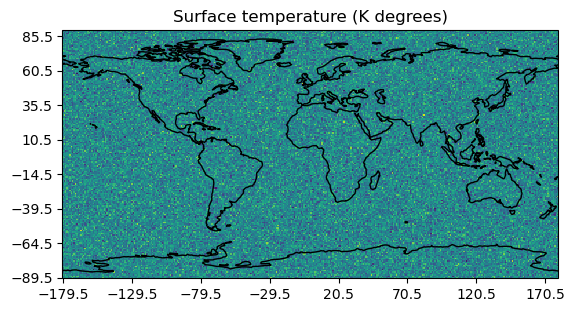

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
f = h5py.File("attrs.h5")
ax.pcolormesh(f["lon"][...], f["lat"][...], f["tas"][0]) # extraer el primer paso de tiempo de temperaturas
ax.set_xticks(f["lon"][::50])
ax.set_yticks(f["lat"][::25])
ax.set_title(f"Surface temperature ({f['tas'].attrs['units'].decode('ascii')} degrees)")
ax.coastlines()
f.close()

# netCDF <a class="anchor" id="netcdf"/>

netCDF (Network Common Data Form) is a set of software libraries and machine-independent data formats that support the creation, access, and sharing of array-oriented scientific data. It is also a community standard for sharing scientific data.

Since version 4 netCDF files are HDF5 files under the hood. We can apply all of our knowledge to netCDF datasets (chunking, compression).

In order to get familiar with netCDF, we will work with datasets from [CMIP](https://en.wikipedia.org/wiki/Coupled_Model_Intercomparison_Project) from the [ACCESS-ESM1-5 model](https://research.csiro.au/access/about/esm1-5/). The GCM is described in the [paper](https://doi.org/10.1071/ES19035). netCDF files can be located in [ESGF](https://esgf-node.llnl.gov/search/cmip6?mip_era=CMIP6&activity_id=ScenarioMIP&product=&source_id=ACCESS-CM2%2CACCESS-ESM1-5&experiment_id=ssp245%2Cssp585&variant_label=r1i1p1f1%2Cr1i1p1f2&grid_label=gn&table_id=&frequency=day%2Cmon&variable_id=tas).

You may find the netCDF files in Moodle too (`tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc` and `tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc`).

In [8]:
import h5py
import numpy as np
import netCDF4
import xarray
import matplotlib.pyplot as plt

Plot temperatures for `ssp245` and `ssp585` using netCDF4 and matplotlib.

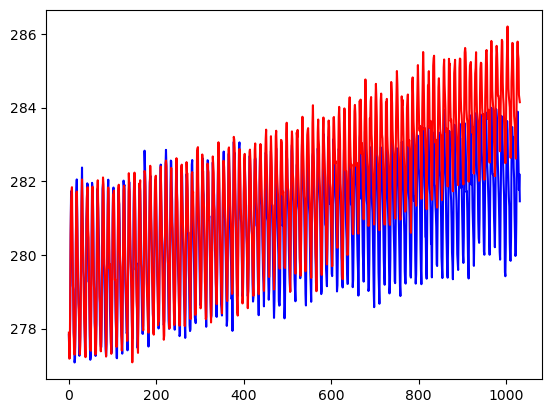

In [9]:
ds1 = netCDF4.Dataset("tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")
ds2 = netCDF4.Dataset("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")

fig, ax = plt.subplots()
x = np.arange(0,ds1["time"].shape[0])
ax.plot(
    x,
    ds1["tas"][:].mean(axis=(1,2)),
    c="blue")
ax.plot(
    x,
    ds2["tas"][:].mean(axis=(1,2)),
    c="red")

ds1.close()
ds2.close()

Same plot using xarray and averaging by year (note how xarray fills the plot using metadata from the file).

C:\Users\Johana Combita\.conda\envs\h5py\Lib\site-packages\xarray\groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Johana Combita\.conda\envs\h5py\Lib\site-packages\xarray\groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


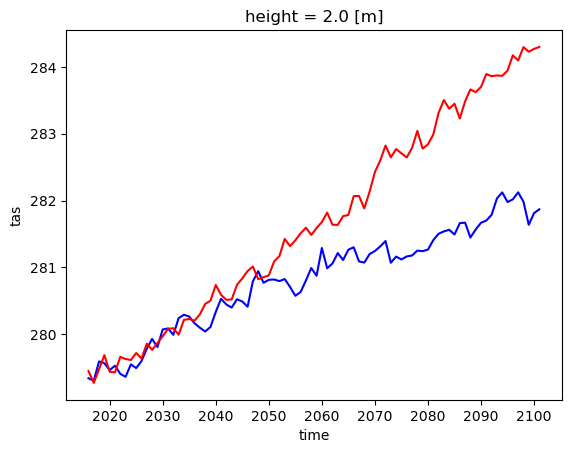

In [10]:
ds1 = xarray.open_dataset("tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")
ds2 = xarray.open_dataset("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")
    
fig, ax = plt.subplots()
ds1["tas"].mean(["lat", "lon"]).resample({"time": "1Y"}).mean().plot(ax=ax,c="b")
ds2["tas"].mean(["lat", "lon"]).resample({"time": "1Y"}).mean().plot(ax=ax,c="r")

ds1.close()
ds2.close()

Since version 4 netCDF files are HDF5 files under the hood. We can apply all of our knowledge to netCDF datasets (chunking, compression).

In [13]:
!h5dump -d tas -A tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc

HDF5 "tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc" {
DATASET "tas" {
   DATATYPE  H5T_IEEE_F32LE
   DATASPACE  SIMPLE { ( 1032, 145, 192 ) / ( H5S_UNLIMITED, 145, 192 ) }
   ATTRIBUTE "DIMENSION_LIST" {
      DATATYPE  H5T_VLEN { H5T_REFERENCE { H5T_STD_REF_OBJECT } }
      DATASPACE  SIMPLE { ( 3 ) / ( 3 ) }
      DATA {
      (0): (DATASET 2406513382832 "/time"), (DATASET 2406513382400 "/lat"),
      (2): (DATASET 2406513382176 "/lon")
      }
   }
   ATTRIBUTE "_FillValue" {
      DATATYPE  H5T_IEEE_F32LE
      DATASPACE  SIMPLE { ( 1 ) / ( 1 ) }
      DATA {
      (0): 1e+20
      }
   }
   ATTRIBUTE "cell_measures" {
      DATATYPE  H5T_STRING {
         STRSIZE 16;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_ASCII;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "area: areacella"
      }
   }
   ATTRIBUTE "cell_methods" {
      DATATYPE  H5T_STRING {
         STRSIZE 17;
         STRPAD H5T_STR_NULLTERM;
         CSET H

In [14]:
f = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")
list(f)

['time',
 'time_bnds',
 'lat',
 'lat_bnds',
 'lon',
 'bnds',
 'lon_bnds',
 'height',
 'tas']

In [15]:
dict(f.attrs)

{'_nc3_strict': np.int32(1),
 'Conventions': np.bytes_(b'CF-1.7 CMIP-6.2'),
 'activity_id': np.bytes_(b'ScenarioMIP'),
 'branch_method': np.bytes_(b'standard'),
 'branch_time_in_child': array([60265.]),
 'branch_time_in_parent': array([60265.]),
 'creation_date': np.bytes_(b'2019-11-15T02:53:44Z'),
 'data_specs_version': np.bytes_(b'01.00.30'),
 'experiment': np.bytes_(b'update of RCP4.5 based on SSP2'),
 'experiment_id': np.bytes_(b'ssp245'),
 'external_variables': np.bytes_(b'areacella'),
 'forcing_index': array([1], dtype=int32),
 'frequency': np.bytes_(b'mon'),
 'further_info_url': np.bytes_(b'https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCESS-ESM1-5.ssp245.none.r1i1p1f1'),
 'grid': np.bytes_(b'native atmosphere N96 grid (145x192 latxlon)'),
 'grid_label': np.bytes_(b'gn'),
 'history': np.bytes_(b'2019-11-15T02:53:44Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.'),
 'initialization_index': array([1], dtype=int32),
 'institution': np.bytes_(b'Com

In [16]:
dict(f["time"].attrs)

{'CLASS': np.bytes_(b'DIMENSION_SCALE'),
 'NAME': np.bytes_(b'time'),
 '_Netcdf4Dimid': np.int32(0),
 'bounds': np.bytes_(b'time_bnds'),
 'units': np.bytes_(b'days since 1850-01-01'),
 'calendar': np.bytes_(b'proleptic_gregorian'),
 'axis': np.bytes_(b'T'),
 'long_name': np.bytes_(b'time'),
 'standard_name': np.bytes_(b'time'),
 'REFERENCE_LIST': array([(<HDF5 object reference>, 0), (<HDF5 object reference>, 0)],
       dtype={'names': ['dataset', 'dimension'], 'formats': ['O', '<i4'], 'offsets': [0, 8], 'itemsize': 16})}

In [17]:
print(f["tas"].shape)
print(f["tas"].dtype)
print(dict(f["tas"].attrs))

(1032, 145, 192)
float32
{'standard_name': np.bytes_(b'air_temperature'), 'long_name': np.bytes_(b'Near-Surface Air Temperature'), 'comment': np.bytes_(b'near-surface (usually, 2 meter) air temperature'), 'units': np.bytes_(b'K'), 'cell_methods': np.bytes_(b'area: time: mean'), 'cell_measures': np.bytes_(b'area: areacella'), 'history': np.bytes_(b"2019-11-15T02:53:41Z altered by CMOR: Treated scalar dimension: 'height'. 2019-11-15T02:53:41Z altered by CMOR: replaced missing value flag (-1.07374e+09) with standard missing value (1e+20)."), 'coordinates': np.bytes_(b'height'), 'missing_value': array([1.e+20], dtype=float32), '_FillValue': array([1.e+20], dtype=float32), 'DIMENSION_LIST': array([array([<HDF5 object reference>], dtype=object),
       array([<HDF5 object reference>], dtype=object),
       array([<HDF5 object reference>], dtype=object)], dtype=object)}


In [18]:
dict(f["bnds"].attrs)

{'CLASS': np.bytes_(b'DIMENSION_SCALE'),
 'NAME': np.bytes_(b'This is a netCDF dimension but not a netCDF variable.         2'),
 '_Netcdf4Dimid': np.int32(3),
 'REFERENCE_LIST': array([(<HDF5 object reference>, 1), (<HDF5 object reference>, 1),
        (<HDF5 object reference>, 1)],
       dtype={'names': ['dataset', 'dimension'], 'formats': ['O', '<i4'], 'offsets': [0, 8], 'itemsize': 16})}

In [19]:
dict(f["height"].attrs)

{'units': np.bytes_(b'm'),
 'axis': np.bytes_(b'Z'),
 'positive': np.bytes_(b'up'),
 'long_name': np.bytes_(b'height'),
 'standard_name': np.bytes_(b'height')}

In [ ]:
f.close()     #bounds
    ds.createVariable("bnds", f["bnds"].dtype, (,))

Using the [netCDF4](https://unidata.github.io/netcdf4-python) API, try to reproduce the contents of the `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc` file.

Tips:

- Create dimensions - Use [Dataset.createDimension](https://unidata.github.io/netcdf4-python/#Dataset.createDimension).
- Create variables - Use [Dataset.createVariable](https://unidata.github.io/netcdf4-python/#Dataset.createVariable).
- Create attributes - Use [Variable.setncattr](https://unidata.github.io/netcdf4-python/#Variable.setncattr).
- At each step, execute `h5dump` on the file to see how it changes.

In [18]:
import netCDF4
import h5py

# if you want, take data from the source file using h5py instead of "manually" looking at it
f = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")

# byteorder_to_endian( hdf5_dataset.dtype.byteorder )
def byteorder_to_endian(x):
    endianness = "native"
    
    if x == "<":
        endianness = "little"
    elif x == ">":
        endianness = "big"
        
    return endianness

with netCDF4.Dataset("test.nc", "w") as ds:
    #Traer atributos globales
    for attr in f.attrs: 
        if not attr.startswith("_"):
            ds.setncattr(attr, f.attrs[attr])
            
    #creando dimension
    ds.createDimension("time", f["time"].shape[0])
    ds.createDimension("lat", f["lat"].shape[0]) 
    ds.createDimension("lon", f["lon"].shape[0])
    ds.createDimension("bnds", 2) 

    #creando variables 
    ds.createVariable("time", f["time"].dtype, ("time",), endian=byteorder_to_endian(f["time"].dtype.byteorder), zlib=True, chunksizes=f["time"].chunks, complevel=f["time"].compression, fill_value=None)
    ds.createVariable("lat", f["lat"].dtype, ("lat",) , endian=byteorder_to_endian(f["lat"].dtype.byteorder))
    ds.createVariable("lon", f["lon"].dtype, ("lon",) , endian=byteorder_to_endian(f["lon"].dtype.byteorder))
    ds.createVariable("height", f["height"].dtype, () , endian=byteorder_to_endian(f["height"].dtype.byteorder))
    
    #límites de coordenadas
    ds.createVariable("time_bnds", f["time"].dtype, ("time", "bnds"), endian=byteorder_to_endian(f["time"].dtype.byteorder), zlib=True, complevel=1, chunksizes=(1, 2))
    ds.createVariable("lat_bnds", f["lat"].dtype, ("lat", "bnds"), endian=byteorder_to_endian(f["lat"].dtype.byteorder), zlib=True, complevel=1, chunksizes=(145, 2))
    ds.createVariable("lon_bnds", f["lon"].dtype, ("lon", "bnds"), endian=byteorder_to_endian(f["lon"].dtype.byteorder), zlib=True, complevel=1, chunksizes=(192, 2))
    
    #creando array multidimensional tas
    ds.createVariable("tas", f["tas"].dtype, ("time", "lat", "lon"), endian=byteorder_to_endian(f["tas"].dtype.byteorder), zlib=True, complevel=1, chunksizes=(1, 145, 192))

    #atributos
    elements = ("time", "lat", "lon", "height", "tas")
    for e in elements: 
        for attr in f[e].attrs:
            if not attr.startswith("_"):
                if not attr.startswith("DIMENSION_LIST"):
                    if not attr.startswith("CLASS"):
                        if not attr.startswith("NAME"):
                            if not attr.startswith("REFERENCE_LIST"):
                                ds[e].setncattr(attr, f[e].attrs[attr])
    
    #agregando valores 
    ds["time"][...] = f["time"][...]
    ds["lat"][...] = f["lat"][...]
    ds["lon"][...] = f["lon"][...]
    ds["tas"][...] = f["tas"][...]

    f.close()

In [19]:
!ncdump -hs test.nc

netcdf test {
dimensions:
	time = 1032 ;
	lat = 145 ;
	lon = 192 ;
	bnds = 2 ;
variables:
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1850-01-01" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_Endianness = "little" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
		lon:_Storage = "contiguous" ;
		lon:_Endianness = "little" ;
	double height ;
		height:units = "m" ;
		height:axis = "Z" ;
		height:positive = "up" ;
		height:long_name = "height" ;
		height:standard_name = "height"

In [13]:
!ncdump -hs tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc

netcdf tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012 {
dimensions:
	time = UNLIMITED ; // (1032 currently)
	lat = 145 ;
	lon = 192 ;
	bnds = 2 ;
variables:
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1850-01-01" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_Endianness = "little" ;
	double time_bnds(time, bnds) ;
		time_bnds:_Storage = "chunked" ;
		time_bnds:_ChunkSizes = 1, 2 ;
		time_bnds:_DeflateLevel = 1 ;
		time_bnds:_Endianness = "little" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "chunked" ;
		lat_bnds:_ChunkSizes = 145, 2 ;
		lat_bnds:_DeflateLevel = 1 ;
		lat_bn

# Dimension scales <a class="anchor" id="dimension-scales"/>

Datasets are multidimensional arrays. HDF5 provides support for labeling the dimensions and associating one or more "dimension scales" with each dimension. A dimension scale is simply another HDF5 dataset. In principle, the length of the multidimensional array along the dimension of interest should be equal to the length of the dimension scale, but HDF5 does not enforce this property.

In [1]:
import h5py

Using **h5py**, try to reproduce the contents of the `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc` file. In order to verify that the file is correct, perform a `ncdump` on it.

Tips:

- Dimension scales - See the [docs](https://docs.h5py.org/en/stable/high/dims.html).
- Make a coordinate variable a dimension scale - `f["time"].make_scale("time")`
- Attach a dimension scale to a data variable - `f["tas"].dims[0].attach_scale(f["time"])`
- At each step, execute `h5dump` on the file to see the changes.

In [8]:
# for variable data, read it from the source file
src = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")

with h5py.File("test2.nc", "w") as f:
    #Traer atributos globales
    for attr in src.attrs: #trae todos los atributos
        if not attr.startswith("_"):
            f.attrs.create(attr, src.attrs[attr])

    #creación de variables, con sus atributos y coordenada (si aplica)
    #Time
    f.create_dataset(
        "time",
        src["time"].shape,
        dtype=src["time"].dtype,
        chunks=src["time"].chunks,
        compression=src["time"].compression, fillvalue=0.0)
    f["time"].make_scale("time")
    f["time"][:] = src["time"][:]

    #latitude
    f.create_dataset("lat", src["lat"].shape, dtype=src["lat"].dtype, chunks=src["lat"].chunks, compression=src["lat"].compression, fillvalue=0.0) #lo ultimo para que no aparezca nofill
    f["lat"].make_scale("lat")
    f["lat"][:] = src["lat"][:]

    #longitude
    f.create_dataset("lon", src["lon"].shape, dtype=src["lon"].dtype, chunks=src["lon"].chunks, compression=src["lon"].compression, fillvalue=0.0)
    f["lon"].make_scale("lon")
    f["lon"][:] = src["lon"][:]

    #height
    f.create_dataset("height", src["height"].shape, dtype=src["height"].dtype, fillvalue=0.0)
    f["height"][()] = src["height"][()]

    #Temperature
    f.create_dataset("tas", src["tas"].shape, dtype=src["tas"].dtype, chunks=src["tas"].chunks, compression=src["tas"].compression, fillvalue=0.0)
    f["tas"][:] = src["tas"][:]

    #atributos
    elements = ("time", "lat", "lon", "height", "tas")
    for e in elements: 
        for attr in src[e].attrs: #trae todos los atributos
            if not attr.startswith("_"):
                if not attr.startswith("DIMENSION_LIST"):
                    if not attr.startswith("CLASS"):
                        if not attr.startswith("NAME"):
                            if not attr.startswith("REFERENCE_LIST"):
                                f[e].attrs.create(attr, src[e].attrs[attr])

    # Adjuntar escalas a las dimensiones
    f["tas"].dims[0].attach_scale(f["time"])
    f["tas"].dims[1].attach_scale(f["lat"])
    f["tas"].dims[2].attach_scale(f["lon"])

    #bounds
    f.create_dataset("bnds", src["bnds"].shape, dtype=src["bnds"].dtype)
    f["bnds"].make_scale("This is a netCDF dimension but not a netCDF variable.         2") 

    f.create_dataset("lat_bnds", src["lat_bnds"].shape, dtype=src["lat_bnds"].dtype,chunks=src["lat_bnds"].chunks, compression=src["lat_bnds"].compression, fillvalue=0.0)
    f["lat_bnds"][:] = src["lat_bnds"][:]
    f.create_dataset("lon_bnds", src["lon_bnds"].shape, dtype=src["lon_bnds"].dtype, chunks=src["lon_bnds"].chunks, compression=src["lon_bnds"].compression, fillvalue=0.0)
    f["lon_bnds"][:] = src["lon_bnds"][:]
    f.create_dataset("time_bnds", src["time_bnds"].shape, dtype=src["time_bnds"].dtype, chunks=src["time_bnds"].chunks, compression=src["time_bnds"].compression, fillvalue=0.0)
    f["time_bnds"][:] = src["time_bnds"][:]

    # Adjuntar límites
    f["lat_bnds"].dims[0].attach_scale(f["lat"]) 
    f["lon_bnds"].dims[0].attach_scale(f["lon"])  
    f["time_bnds"].dims[0].attach_scale(f["time"])

    f["lat_bnds"].dims[1].attach_scale(f["bnds"])
    f["lon_bnds"].dims[1].attach_scale(f["bnds"])  
    f["time_bnds"].dims[1].attach_scale(f["bnds"])


src.close()

In [9]:
!ncdump -hs test2.nc

netcdf test2 {
dimensions:
	bnds = 2 ;
	lat = 145 ;
	lon = 192 ;
	time = 1032 ;
variables:
	double height ;
		height:units = "m" ;
		height:axis = "Z" ;
		height:long_name = "height" ;
		height:standard_name = "height" ;
		height:positive = "up" ;
		height:_Storage = "contiguous" ;
		height:_Endianness = "little" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "chunked" ;
		lat_bnds:_ChunkSizes = 145, 2 ;
		lat_bnds:_DeflateLevel = 4 ;
		lat_bnds:_Endianness = "little" ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
		lon:_Storage = "contiguous" ;
		lon:_Endianness = "little" ;
	double lon_bnds(lon, bnds) ;
		lon_bnds:_Storage = "chunked" ;

In [21]:
!ncdump -hs tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc

netcdf tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012 {
dimensions:
	time = UNLIMITED ; // (1032 currently)
	lat = 145 ;
	lon = 192 ;
	bnds = 2 ;
variables:
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1850-01-01" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_Endianness = "little" ;
	double time_bnds(time, bnds) ;
		time_bnds:_Storage = "chunked" ;
		time_bnds:_ChunkSizes = 1, 2 ;
		time_bnds:_DeflateLevel = 1 ;
		time_bnds:_Endianness = "little" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "chunked" ;
		lat_bnds:_ChunkSizes = 145, 2 ;
		lat_bnds:_DeflateLevel = 1 ;
		lat_bn

# Virtual dataset <a class="anchor" id="virtual-dataset"/>

Virtual datasets allow a number of real datasets to be mapped together into a single, sliceable dataset via an interface layer. The mapping can be made ahead of time, before the parent files are written, and is transparent to the parent dataset characteristics (chunking, compression etc…). The datasets can be meshed in arbitrary combinations, and even the data type converted. Once a virtual dataset has been created, it can be read just like any other HDF5 dataset.

Using **h5py**, perform an ETL over the files `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc` and `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc`. Create a Virtual Dataset (VDS) with a time dimension and coordinate that spans the full time period from 2015 to 2300.

Finally, use xarray to check that the ETL has been performed succesfully. Also, plot the spatial mean of temperature resampling by year.

Tips:

- h5py Virtual Dataset - See the [docs](https://docs.h5py.org/en/stable/vds.html).
- Create a VirtualLayout object representing the dimensions and data type of the virtual dataset.
- Create a number of VirtualSource objects, representing the datasets the array will be built from.
- Map slices from the sources into the layout.
- Convert the VirtualLayout object into a virtual dataset in an HDF5 file.

In [1]:
import h5py
import xarray
import numpy as np

In [8]:
src1 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")
src2 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc")

with h5py.File("vds.h5", "w") as f:
    #calculando tamaño de dimension tiempo final
    time_shape = src1["time"].shape[0] + src2["time"].shape[0]
    #creación de virtual layout de time
    time_layout = h5py.VirtualLayout((time_shape,), src1["time"].dtype)
    #Rellenar layout con virtual source
    time_layout[0:src1["time"].shape[0], ...] = h5py.VirtualSource(src1.filename, "time", src1["time"].shape)
    time_layout[src1["time"].shape[0]:, ...] = h5py.VirtualSource(src2.filename, "time", src2["time"].shape)
    #CRearlo en dataset virtual (agregar dimension y atributos)
    f.create_virtual_dataset("time", time_layout)
    f["time"].make_scale("time")
    
    #creación de virtual layout de lat
    lat_layout = h5py.VirtualLayout(src1["lat"].shape, src1["lat"].dtype)
    lat_layout[0:src1["lat"].shape[0], ...] = h5py.VirtualSource(src1.filename, "lat", src1["lat"].shape)
    f.create_virtual_dataset("lat", lat_layout)
    f["lat"].make_scale("lat")

    #creación de virtual layout de lon
    lon_layout = h5py.VirtualLayout(src1["lon"].shape, src1["lon"].dtype)
    lon_layout[0:src1["lon"].shape[0], ...] = h5py.VirtualSource(src1.filename, "lon", src1["lon"].shape)
    f.create_virtual_dataset("lon", lon_layout)
    f["lon"].make_scale("lon")

    #creación de virtual layout de heigth
    height_layout = h5py.VirtualLayout((), dtype = src1["height"].dtype)
    height_layout[()] = h5py.VirtualSource(src1.filename, "height", shape=())
    f.create_virtual_dataset("height", height_layout)

    #creación de virtual layout de tas
    tas_layout = h5py.VirtualLayout(
                    shape = (time_shape, src1["lat"].shape[0], src1["lon"].shape[0]),
                            dtype=src1["tas"].dtype) 
    tas_layout[0:src1["time"].shape[0], :, :] = h5py.VirtualSource(src1.filename, "tas", src1["tas"].shape) 
    tas_layout[src1["time"].shape[0]:, :, :] = h5py.VirtualSource(src2.filename, "tas", src2["tas"].shape)
    f.create_virtual_dataset("tas", tas_layout)

    #atributos
    elements = ("time", "lat", "lon", "height", "tas")
    for e in elements: 
        for attr in src1[e].attrs: #trae todos los atributos
            if not attr.startswith("_"):
                if not attr.startswith("DIMENSION_LIST"):
                    if not attr.startswith("CLASS"):
                        if not attr.startswith("NAME"):
                            if not attr.startswith("REFERENCE_LIST"):
                                f[e].attrs.create(attr, src1[e].attrs[attr])
    
    #scales 
    f["tas"].dims[0].attach_scale(f["time"])
    f["tas"].dims[1].attach_scale(f["lat"])
    f["tas"].dims[2].attach_scale(f["lon"])

    #crear bounds
    f.create_dataset("bnds", src1["bnds"].shape, dtype=src1["bnds"].dtype)
    f["bnds"].make_scale("This is a netCDF dimension but not a netCDF variable.         2") 

    time_bnds_layout = h5py.VirtualLayout((time_shape, 2), dtype=src1["time_bnds"].dtype)
    time_bnds_layout[0:src1["time"].shape[0], :] = h5py.VirtualSource(src1.filename, "time_bnds", src1["time_bnds"].shape)
    time_bnds_layout[src1["time"].shape[0]:, :] = h5py.VirtualSource(src2.filename, "time_bnds", src2["time_bnds"].shape)
    f.create_virtual_dataset("time_bnds", time_bnds_layout)

    lat_bnds_layout = h5py.VirtualLayout((src1["lat"].shape[0], 2), dtype=src1["lat_bnds"].dtype)
    lat_bnds_layout[0:src1["lat"].shape[0], :] = h5py.VirtualSource(src1.filename, "lat_bnds", src1["lat_bnds"].shape)
    f.create_virtual_dataset("lat_bnds", lat_bnds_layout)

    lon_bnds_layout = h5py.VirtualLayout((src1["lon"].shape[0], 2), dtype=src1["lon_bnds"].dtype)
    lon_bnds_layout[0:src1["lon"].shape[0], :] = h5py.VirtualSource(src1.filename, "lon_bnds", src1["lon_bnds"].shape)
    f.create_virtual_dataset("lon_bnds", lon_bnds_layout)

    # Adjuntar límites
    f["lat_bnds"].dims[0].attach_scale(f["lat"]) 
    f["lon_bnds"].dims[0].attach_scale(f["lon"])  
    f["time_bnds"].dims[0].attach_scale(f["time"])

    f["lat_bnds"].dims[1].attach_scale(f["bnds"])
    f["lon_bnds"].dims[1].attach_scale(f["bnds"])  
    f["time_bnds"].dims[1].attach_scale(f["bnds"])

src1.close()
src2.close()

In [9]:
!ncdump -v time -s vds.h5

netcdf vds {
dimensions:
	bnds = 2 ;
	lat = 145 ;
	lon = 192 ;
	time = 3432 ;
variables:
	double height ;
		height:units = "m" ;
		height:axis = "Z" ;
		height:positive = "up" ;
		height:long_name = "height" ;
		height:standard_name = "height" ;
		height:_Storage = "unknown" ;
		height:_Endianness = "little" ;
		height:_NoFill = "true" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "unknown" ;
		lat:_Endianness = "little" ;
		lat:_NoFill = "true" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "unknown" ;
		lat_bnds:_Endianness = "little" ;
		lat_bnds:_NoFill = "true" ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
		lon:_Storage = "unknown" ;
		lon:_Endianness = "little" ;
		lon:_NoFill = "true" ;
	double lon_bnds(lon, bnds) ;
	

In [18]:
!ncdump -hs tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc

netcdf tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012 {
dimensions:
	time = UNLIMITED ; // (1032 currently)
	lat = 145 ;
	lon = 192 ;
	bnds = 2 ;
variables:
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1850-01-01" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_Endianness = "little" ;
	double time_bnds(time, bnds) ;
		time_bnds:_Storage = "chunked" ;
		time_bnds:_ChunkSizes = 1, 2 ;
		time_bnds:_DeflateLevel = 1 ;
		time_bnds:_Endianness = "little" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "chunked" ;
		lat_bnds:_ChunkSizes = 145, 2 ;
		lat_bnds:_DeflateLevel = 1 ;
		lat_bn

In [10]:
# everything ok?
ds = xarray.open_dataset("vds.h5", use_cftime=True)
src1 = xarray.open_dataset("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc", use_cftime=True)
src2 = xarray.open_dataset("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc", use_cftime=True)

print("VDS mean: {}, source mean: {}, OK: {}".format(
    ds["tas"].sel(time=slice("2015-01-01", "2100-12-31")).mean().values,
    src1["tas"].mean().values,
    (ds["tas"].sel(time=slice("2015-01-01", "2100-12-31")).mean() == src1["tas"].mean()).values))

print("VDS mean: {}, source mean: {}, OK: {}".format(
    ds["tas"].sel(time=slice("2101-01-01", "2300-12-31")).mean().values,
    src2["tas"].mean().values,
    (ds["tas"].sel(time=slice("2101-01-01", "2300-12-31")).mean() == src2["tas"].mean()).values))

VDS mean: 281.6891784667969, source mean: 281.6891784667969, OK: True
VDS mean: 288.7425537109375, source mean: 288.7425537109375, OK: True


# Discrete Sampling Geometries <a class="anchor" id="dsg"/>

Discrete sampling geometry datasets are characterized by a dimensionality that is lower than that of the space-time region that is sampled.

The [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) is an integrated database of daily climate summaries from land surface stations across the globe. GHCNd contains records from more than 100,000 stations in 180 countries and territories. NCEI provides numerous daily variables, including maximum and minimum temperature, total daily precipitation, snowfall, and snow depth. Both record length and period of record vary by station and cover intervals ranging from less than a year to more than 175 years. See [this](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt).

In this exercise we will store a small subset of GHCNd in two different formats, as a Coordinate Matrix and as a Discrete Sampling Geometry. For the Coordinate Matrix you will use [compound data types](https://docs.h5py.org/en/stable/high/dataset.html#reading-writing-data) and you will need to use [resizable datasets](https://docs.h5py.org/en/stable/high/dataset.html#resizable-datasets) for the Discrete Sampling Geometry.

In [1]:
import math, codecs
import numpy as np
import pandas as pd
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime, datetime

Load an plot stations from GHCNd in the region of Spain and Canary Islands.

In [2]:
def parse_station(line):
    station = tuple([
        line[0:11].rstrip(),
        float(line[12:20].rstrip()),
        float(line[21:30].rstrip()),
        float(line[31:37].rstrip()),
        line[38:40].rstrip(),
        line[41:71].rstrip(),
        line[72:75].rstrip(),
        line[76:79].rstrip(),
        line[80:85].rstrip('\n').rstrip(),
    ])

    return station

def parse_stations(f):
    for line in codecs.open(f, 'r', encoding='utf-8', errors='ignore'):
        station = parse_station(line)
        yield station

csvs = [
    "SP000008027.csv",
    "SP000008181.csv",
    "SPE00119711.csv",
    "SPE00119882.csv",
    "SPE00119936.csv",
    "SPE00119972.csv",
    "SPE00120278.csv",
    "SPE00120458.csv",
    "SPE00120467.csv",
]

values_dtype = np.dtype([
    ('station_id', 'S11'),
    ('date', 'S8'),
    ('var', 'S4'),
    ('value', 'f4'),
    ('mflag', 'S1'),
    ('qflag', 'S1'),
    ('sflag', 'S1'),
    ('obstime', 'S4'),
])

stations_dtype = np.dtype([
            ('station_id', 'S11'),
            ('lat', 'f8'),
            ('lon', 'f8'),
            ('elevation', 'f4'),
            ('state', 'S2'),
            ('name', h5py.string_dtype("utf-8", 30)),
            ('gsn_flag', 'S3'),
            ('hcn_crn_flag', 'S3'),
            ('wmo_id', 'S5'),
])
stations_file = "stations.txt"
stations = np.array([x for x in parse_stations(stations_file)], dtype=stations_dtype)
stations

array([(b'SP000008027', 43.3075,  -2.0392, 251., b'', b'SAN SEBASTIAN - IGUELDO', b'GSN', b'', b'08027'),
       (b'SP000008181', 41.2928,   2.0697,   4., b'', b'BARCELONA/AEROPUERTO', b'GSN', b'', b'08181'),
       (b'SPE00119711', 43.3669,  -8.4192,  58., b'', b'A CORUNA', b'', b'', b'08001'),
       (b'SPE00119882', 39.5556,   2.6264,   3., b'', b'PALMA DE MALLORCA CMT', b'', b'', b'08306'),
       (b'SPE00119936', 36.5008,  -6.2567,   1., b'', b'CADIZ', b'', b'', b'08452'),
       (b'SPE00119972', 43.4644,  -3.8189,  64., b'', b'SANTANDER CENTRO', b'', b'', b''),
       (b'SPE00120278', 40.4667,  -3.5556, 609., b'', b'MADRID/BARAJAS', b'', b'', b'08221'),
       (b'SPE00120458', 28.4631, -16.2553,  35., b'', b'STA. CRUZ DE TENERIFE', b'', b'', b'60020'),
       (b'SPE00120467', 28.4775, -16.3292, 632., b'', b'TENERIFE/LOS RODEOS', b'', b'', b'60015')],
      dtype=[('station_id', 'S11'), ('lat', '<f8'), ('lon', '<f8'), ('elevation', '<f4'), ('state', 'S2'), ('name', 'S30'), ('gsn_f

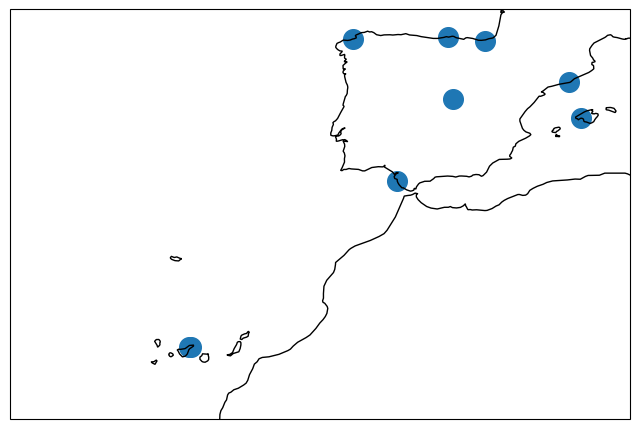

In [3]:
fig=plt.figure(figsize=(8,6))

ax=fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-25,5,25,44])
ax.scatter(stations["lon"], stations["lat"], s=200)

Create the coordinate matrix dataset.

<Axes: >

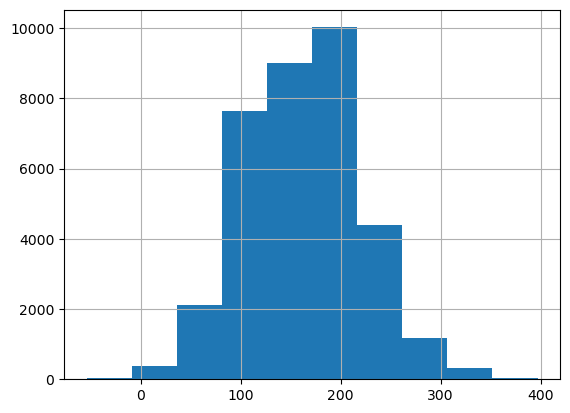

In [4]:
# write data in COO format
with h5py.File("coo.h5", "w") as f:
    f.create_dataset("stations", shape=(len(stations), ), dtype = stations.dtype)
    f.create_dataset("values", shape=(0,), maxshape=(None,), dtype=values_dtype)

    f["stations"][...] = stations
    names = stations[:]["station_id"]

    counter = 0
    for st in names:
        fname = st.decode("utf-8") + ".csv"
        data = np.genfromtxt(fname,dtype=values_dtype, delimiter=",")
        
        new_size = len(data) + counter
        f["values"].resize((new_size, ))
        f["values"][counter:new_size] = data

        counter = new_size
        
# load data and plot
with h5py.File("coo.h5", "r") as f:
    st = stations[0]["station_id"]
    all_data = f["values"][...]
    st_data = all_data[all_data[:]["station_id"] == st]

df = pd.DataFrame(st_data)
df[df["var"] == b"TMAX"]["value"].hist()

Create the discrete sampling geometry dataset.

In [ ]:
MISSING = 999.9
VS = [
    # name -> original name
    # cfname -> name in the netCDF file
    # attrs -> variable attributes
    {
        "name": "PRCP",
        "cfname": "pr",
        "attrs":
            {
                "standard_name": "precipitation_flux",
                "coordinates": "time lat lon alt",
                "units": "kg m-2 s-1"
            }
    },
    {
        "name": "TMAX",
        "cfname": "tasmax",
        "attrs":
            {
                "standard_name": "air_temperature",
                "coordinates": "time lat lon alt",
                "units": "K",
            }
    },
    {
        "name": "TMIN",
        "cfname": "tasmin",
        "attrs":
            {
                "standard_name": "air_temperature",
                "coordinates": "time lat lon alt",
                "units": "K",
            }
    },
]

def create_char_attr(o,k,v):
    o.attrs.create(k,v,dtype="S"+str(len(v)))

def create_dimension(g,n,s,t):
    d = f.create_dataset(n, s, dtype=t)
    d.attrs.create(
        "NAME",
        "This is a netCDF dimension but not a netCDF variable.    " + n,
        dtype="S"+str(len("This is a netCDF dimension but not a netCDF variable.    " + n)))

    return d

with h5py.File("dsg.h5", "w") as f:
    create_char_attr(f, "featureType", "TimeSeries")
    create_char_attr(f, "cdm_data_type", "TimeSeries")
    create_char_attr(f, "Conventions", "COARDS, CF-1.6, ACDD-1.3")

    name_strlen_dset = create_dimension(f, "name_strlen", (11,), "S1")
    timeseries_dset = create_dimension(f, "timeseries", (len(stations["station_id"]),), "f4")

    lon = f.create_dataset(
        "lon",
        (len(stations["station_id"]),),
        dtype="f4",
        chunks=True,
        compression="gzip",
        shuffle=True,
        fletcher32=True)
    lon.dims[0].attach_scale(timeseries_dset)
    create_char_attr(lon, "standard_name", "longitude")
    create_char_attr(lon, "long_name", "station longitude")
    create_char_attr(lon, "units", "degrees_east")
    create_char_attr(lon, "axis", "X")
    create_char_attr(lon, "_CoordinateAxisType", "Longitude")

    lat = f.create_dataset(
        "lat",
        (len(stations["station_id"]),),
        dtype="f4",
        chunks=True,
        compression="gzip",
        shuffle=True,
        fletcher32=True)
    lat.dims[0].attach_scale(timeseries_dset)
    create_char_attr(lat, "standard_name", "latitude")
    create_char_attr(lat, "long_name", "station latitude")
    create_char_attr(lat, "units", "degrees_north")
    create_char_attr(lat, "axis", "Y")
    create_char_attr(lat, "_CoordinateAxisType", "Latitude")

    alt = f.create_dataset(
        "alt",
        (len(stations["station_id"]),),
        dtype="f4",
        chunks=True,
        compression="gzip",
        shuffle=True,
        fletcher32=True)
    alt.dims[0].attach_scale(timeseries_dset)
    create_char_attr(alt, "long_name", "vertical distance above the surface")
    create_char_attr(alt, "standard_name", "height")
    create_char_attr(alt, "units", "m")
    create_char_attr(alt, "positive", "up")
    create_char_attr(alt, "axis", "Z")
    create_char_attr(alt, "_CoordinateAxisType", "Height")

    station = f.create_dataset(
        "station",
        (len(stations["station_id"]), 11),
        dtype="S1")
    create_char_attr(station, "long_name", "station name")
    create_char_attr(station, "ioos_category", "Identifier")
    create_char_attr(station, "long_name", "Station")
    create_char_attr(station, "cf_role", "timeseries_id")
    station.dims[0].attach_scale(timeseries_dset)
    station.dims[1].attach_scale(name_strlen_dset)

    obs_dset = f.create_dataset(
        "obs",
        (0,),
        "i4",
        maxshape=(None,))
    obs_dset.make_scale("obs")
    obs_dset.attrs.create(
        "NAME",
        "This is a netCDF dimension but not a netCDF variable.    " + "obs",
        dtype="S"+str(len("This is a netCDF dimension but not a netCDF variable.    " + "obs")))
    time = f.create_dataset(
        "time",
        (obs_dset.shape[0],),
        maxshape=(None,),
        dtype="f4",
        chunks=True,
        compression="gzip",
        shuffle=True)
    create_char_attr(time, "standard_name", "time")
    create_char_attr(time, "long_name", "time of measurement")
    create_char_attr(time, "units", "days since 1900-01-01 00:00:00")
    create_char_attr(time, "calendar", "gregorian")
    create_char_attr(time, "axis", "T")
    create_char_attr(time, "_CoordinateAxisType", "Time")
    time.dims[0].attach_scale(obs_dset)

    for v in VS:
        f.create_dataset(
            v["cfname"],
            (obs_dset.shape[0],),
            fillvalue=MISSING,
            maxshape=(None,),
            dtype="f4",
            compression="gzip",
            shuffle=True,
            fletcher32=True)
        f[v["cfname"]].dims[0].attach_scale(obs_dset)
        f[v["cfname"]].attrs.create("missing_value", MISSING)
        for attr in v["attrs"]:
            create_char_attr(f[v["cfname"]], attr, v["attrs"][attr])

    rowSize = f.create_dataset(
        "rowSize",
        (timeseries_dset.shape[0],),
        dtype="i4")
    rowSize.dims[0].attach_scale(timeseries_dset)
    create_char_attr(rowSize, "long_name", "Number of Observations for this TimeSeries")
    create_char_attr(rowSize, "sample_dimension", "obs")

    # values
    lat[:] = stations["lat"]
    lon[:] = stations["lon"]
    alt[:] = stations["elevation"]
    station[:] = stations["station_id"].astype("S11").view("S1").reshape(len(stations),-1)
    f["rowSize"][:] = 0

    # fill the values from CSVs
    for st in stations["station_id"].view("S11").ravel():
        pass

In [ ]:
!ncdump -hs dsg.h5

# Zarr <a class="anchor" id="zarr"/>

Zarr is a format for the storage of chunked, compressed, N-dimensional arrays. Zarr features are:

- Create N-dimensional arrays with any NumPy dtype.
- Chunk arrays along any dimension.
- Compress and/or filter chunks using any NumCodecs codec.
- Store arrays in memory, on disk, inside a Zip file, **on S3**, **GCS**, …
- Read an array concurrently from multiple threads or processes.
- Write to an array concurrently from multiple threads or processes.
- Organize arrays into hierarchies via groups.


In [6]:
import h5py
import zarr
import numpy as np
import xarray
from numcodecs import Blosc, GZip
import gcsfs

Reproduce the random walker example using both h5py and zarr with the following parameters:

- Number of samples (n): 100\_000
- Length of each sample (l): 200

Using h5py:

In [9]:
n = 100_000
l = 200
cs = 1000
chunks = (cs, l)

with h5py.File('walks.h5', 'w') as f:
    d = f.create_dataset('walks', shape=(n, l), dtype='i8')
    for i in range(n // cs):
        walks = (2 * np.random.randint(0, 1 + 1, (cs, l)) - 1).cumsum(axis=1)
        d[i*cs:(i+1)*cs] = walks[:]
        
with h5py.File('walks-compressed.h5', 'w') as f:
    d = f.create_dataset('walks',
                         shape=(n, l),
                         dtype='i8',
                         chunks=chunks,
                         compression="gzip",
                         compression_opts=5)
    for i in range(n // cs):
        walks = (2 * np.random.randint(0, 1 + 1, (cs, l)) - 1).cumsum(axis=1)
        d[i*cs:(i+1)*cs] = walks[:]

Using zarr:

In [10]:
z = zarr.open(
    'walks.zarr',
    mode='w')

z.create_dataset(
    'walks',
    shape=(n, l),
    chunks=chunks,
    dtype='i8',
    compressor=None)

for i in range(n // cs):
    walks = (2 * np.random.randint(0, 1 + 1, (cs, l)) - 1).cumsum(axis=1)
    z["walks"][i*cs:(i+1)*cs] = walks[:]
    
compressor = GZip(5)
d = z.create(
    "compressed",
    shape=(n,l),
    dtype="i8",
    chunks=chunks,
    compressor=compressor,
    overwrite=True)

for i in range(n // cs):
    walks = (2 * np.random.randint(0, 1 + 1, (cs, l)) - 1).cumsum(axis=1)
    d[i*cs:(i+1)*cs] = walks[:]

Accesing cloud climate data using zarr.

In [11]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token="anon")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = "gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historical/r2i1p1f1/Amon/tas/gn/v20200226"

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xarray.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset> Size: 110MB
Dimensions:    (lat: 96, nbnd: 2, lon: 144, time: 1980)
Coordinates:
  * lat        (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
    lat_bnds   (lat, nbnd) float64 2kB dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, nbnd) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time       (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 109MB dask.array<chunksize=(990, 96, 144), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:  time
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           10950.0
    ...                              ...
    tracking_id:                     hdl:21.14100/99cdfde8-5b6d-452b-9b78-62a...
    variable_id:                     tas
    variant_info:                    CMIP6 CESM2-FV2 historical experiment (1...
    variant_label:                   r2i1p1f1
    netcdf_tracking_ids:             hdl:21.14100/99cdfde8-5b6d-452b-9b78-62a...
    version_id:                      v20200226

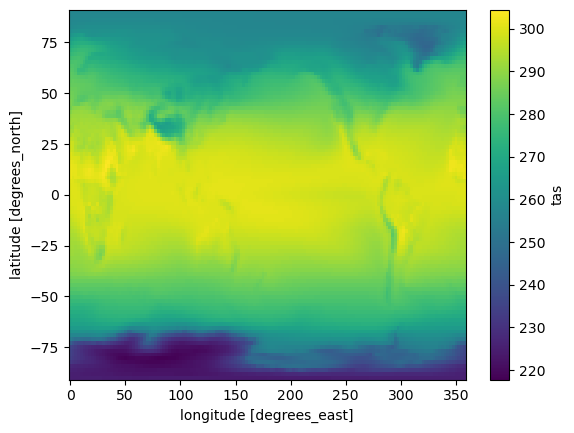

In [12]:
ds["tas"].mean("time").plot()

# Exercise

Using Google Cloud Storage, locate the dataset that contains the time series for the files `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc` and `tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc` (note that the cloud dataset contains concatenated time series rather than individual files like the ones found in [ESGF](https://esgf-data.dkrz.de/search/cmip6-dkrz?mip_era=CMIP6&activity_id=ScenarioMIP&product=&source_id=ACCESS-CM2%2CACCESS-ESM1-5&experiment_id=ssp245%2Cssp585&variant_label=r1i1p1f1%2Cr1i1p1f2&grid_label=gn&table_id=&frequency=day%2Cmon&variable_id=tas)). Plot the spatial mean of the temperature averaged by year.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

In [ ]:
df.query('(activity_id == "ScenarioMIP") & (source_id == "ACCESS-ESM1-5")')